In [1]:


from sklearn.feature_extraction.text import TfidfVectorizer
from concurrent.futures import ThreadPoolExecutor
import emoji

DB_FILE = "loreal_datathon.duckdb"
import tqdm
import os
import re
import duckdb
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('vader_lexicon')

# ----------------------------
# DB Connection
# ----------------------------
def connect_db(db_path=None):
    if db_path is None:
        script_dir = os.getcwd()  # safe for notebooks
        db_path = os.path.join(script_dir, "loreal_datathon.duckdb")
    print(f"[DEBUG] Connecting to database at: {db_path}")
    return duckdb.connect(db_path)


# ----------------------------
# Load comments with optional video metadata
# ----------------------------
def load_comments(conn, include_video_info=True, chunk_size=100000):
    """
    Load comments from DuckDB in chunks with a progress bar.

    Args:
        conn: DuckDB connection.
        include_video_info (bool): Whether to join videos table.
        chunk_size (int): Number of rows per batch.

    Returns:
        pd.DataFrame: All comments loaded and converted to DataFrame.
    """
    print("[DEBUG] Loading comments...")

    if include_video_info:
        query = """
            SELECT c.commentId, c.textOriginal, c.publishedAt, c.videoId, c.channelId,
                   v.title, v.viewCount, v.likeCount
            FROM comments c
            JOIN videos v ON c.videoId = v.videoId
        """
    else:
        query = "SELECT commentId, textOriginal, publishedAt, videoId, channelId FROM comments"

    # Count total rows to show progress
    total_rows = conn.execute(f"SELECT COUNT(*) FROM ({query})").fetchone()[0]
    print(f"[DEBUG] Total comments to load: {total_rows}")

    dfs = []
    offset = 0

    # Use tqdm to show progress
    with tqdm.tqdm(total=total_rows, desc="Loading comments") as pbar:
        while offset < total_rows:
            chunk_query = f"{query} LIMIT {chunk_size} OFFSET {offset}"
            chunk_df = conn.execute(chunk_query).fetchdf()
            dfs.append(chunk_df)
            offset += len(chunk_df)
            pbar.update(len(chunk_df))

    df = pd.concat(dfs, ignore_index=True)
    df['publishedAt'] = pd.to_datetime(df['publishedAt'])
    print(f"[DEBUG] Loaded {len(df)} comments in total")
    return df

# ----------------------------
# Text Cleaning
# ----------------------------
def preprocess_comments(df):
    print("[DEBUG] Preprocessing comments...")
    df['clean_text'] = df['textOriginal'].apply(clean_text)
    print("[DEBUG] Sample cleaned comment:", df['clean_text'].iloc[0])
    return df


# ----------------------------
# Sentiment Analysis
# ----------------------------
def analyze_sentiment(df):
    print("[DEBUG] Analyzing sentiment...")
    sid = SentimentIntensityAnalyzer()
    df['sentiment_score'] = df['clean_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    df['sentiment_label'] = df['sentiment_score'].apply(
        lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral')
    )
    print("[DEBUG] Sample sentiment scores:", df[['sentiment_score', 'sentiment_label']].head())
    return df

def generate_embeddings(df, max_features=512):
    vectorizer = TfidfVectorizer(max_features=max_features)
    embeddings = vectorizer.fit_transform(df['clean_text'])
    return embeddings, vectorizer


# ----------------------------
# Cluster Comments
# ----------------------------
def cluster_comments(df, embeddings, n_clusters=10):
    print(f"[DEBUG] Clustering comments into {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(embeddings)
    print("[DEBUG] Sample clusters:", df['cluster'].value_counts())
    return df, kmeans


# ----------------------------
# Trend Analysis
# ----------------------------
def sentiment_trends(df, min_comments_per_day=10, rolling_window=7):
    print("[DEBUG] Calculating sentiment trends...")
    df = df.copy()
    df['publishedAt'] = pd.to_datetime(df['publishedAt'])
    df.set_index('publishedAt', inplace=True)

    daily_counts = df['sentiment_score'].resample('D').count()
    avg_daily_comments = daily_counts.mean()
    print(f"[DEBUG] Average daily comments: {avg_daily_comments:.2f}")

    if avg_daily_comments >= min_comments_per_day:
        sentiment = df['sentiment_score'].resample('D').mean()
        print("[DEBUG] Using daily aggregation")
    else:
        sentiment = df['sentiment_score'].resample('W').mean()
        print("[DEBUG] Using weekly aggregation")

    if rolling_window:
        sentiment = sentiment.rolling(rolling_window, min_periods=1).mean()

    print("[DEBUG] Sample sentiment trend:", sentiment.head())
    return sentiment


def sentiment_per_video(df):
    print("[DEBUG] Aggregating sentiment per video...")
    result = df.groupby('videoId').agg(
        avg_sentiment=('sentiment_score', 'mean'),
        comment_count=('commentId', 'count'),
        title=('title', 'first'),
        viewCount=('viewCount', 'first')
    ).reset_index()
    print(f"[DEBUG] Processed {len(result)} videos")
    return result


def sentiment_per_channel(df):
    print("[DEBUG] Aggregating sentiment per channel...")
    result = df.groupby('channelId').agg(
        avg_sentiment=('sentiment_score', 'mean'),
        total_comments=('commentId', 'count'),
        total_views=('viewCount', 'sum'),
        total_likes=('likeCount', 'sum')
    ).reset_index()
    print(f"[DEBUG] Processed {len(result)} channels")
    return result

def clean_text(text):
    if not text:
        return ""
    text = re.sub(r"http\S+", "", text)         # remove URLs
    text = emoji.replace_emoji(text, replace="") # remove emojis
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text) # remove punctuation
    return text.lower().strip()




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/andrevarilla/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
# ----------------------------
# 1️⃣ DB Connection & Load Comments
# ----------------------------
print("[DEBUG] Connecting to database...")
script_dir = os.getcwd()  # current working directory
DB_FILE = os.path.join(script_dir, "loreal_datathon.duckdb")  # adjust path if needed

conn = connect_db(db_path=DB_FILE)

print("[DEBUG] Loading comments...")
df = load_comments(conn, include_video_info=True)

conn.close()
print(f"[DEBUG] Loaded {len(df)} comments")
df.head()

[DEBUG] Connecting to database...
[DEBUG] Connecting to database at: /Users/andrevarilla/Git Repos/loreal_datathon/loreal_datathon.duckdb
[DEBUG] Loading comments...
[DEBUG] Loading comments...
[DEBUG] Total comments to load: 4723483


Loading comments: 100%|██████████| 4723483/4723483 [00:03<00:00, 1298542.73it/s]


[DEBUG] Loaded 4723483 comments in total
[DEBUG] Loaded 4723483 comments


,commentId,textOriginal,publishedAt,videoId,channelId,title,viewCount,likeCount
0,2552732,I hope this ain’t seen as rude or smth but I s...,2025-05-05 09:07:26,52362,32921,#grwm to go target #fashion,42999888,1333427
1,2552817,okay you are so pretty😭💗,2024-07-11 07:41:59,68637,21411,YOU WONT BELIEVE THIS,33422556,1953065
2,2552840,"You can do it Too, Belive it",2022-05-24 01:06:13,40805,45539,BEFORE I LEARNED HOW TO TAKE CARE OF MY HAIR #...,3187503,115943
3,2552850,Can I just say you’re really pretty 😌💅,2021-05-13 08:26:37,43866,32659,CONTOUR HACK TIKTOK TREND,104109,2357
4,2552909,This is so sad or think that she only a wife h...,2021-09-20 14:38:13,90030,25950,Pov you’re a girl #shorts,11443295,814810


In [9]:
# ----------------------------
# 2️⃣ Preprocess Comments
# ----------------------------
print("[DEBUG] Preprocessing comments...")
df = preprocess_comments(df)

print("[DEBUG] Sample cleaned comment:")
print(df[['textOriginal', 'clean_text']].head())

[DEBUG] Preprocessing comments...
[DEBUG] Preprocessing comments...
[DEBUG] Sample cleaned comment: i hope this aint seen as rude or smth but i saw you and heard you voice and its so calming 333
[DEBUG] Sample cleaned comment:
                                        textOriginal  \
0  I hope this ain’t seen as rude or smth but I s...   
1                           okay you are so pretty😭💗   
2                       You can do it Too, Belive it   
3             Can I just say you’re really pretty 😌💅   
4  This is so sad or think that she only a wife h...   

                                          clean_text  
0  i hope this aint seen as rude or smth but i sa...  
1                             okay you are so pretty  
2                        you can do it too belive it  
3                 can i just say youre really pretty  
4  this is so sad or think that she only a wife h...  


In [10]:
# ----------------------------
# 3️⃣ Sentiment Analysis
# ----------------------------
print("[DEBUG] Analyzing sentiment...")
df = analyze_sentiment(df)

print("[DEBUG] Sentiment sample:")
print(df[['clean_text', 'sentiment_score', 'sentiment_label']].head())

[DEBUG] Analyzing sentiment...
[DEBUG] Analyzing sentiment...
[DEBUG] Sample sentiment scores:    sentiment_score sentiment_label
0           0.8140        positive
1           0.7198        positive
2           0.0000         neutral
3           0.5413        positive
4          -0.6113        negative
[DEBUG] Sentiment sample:
                                          clean_text  sentiment_score  \
0  i hope this aint seen as rude or smth but i sa...           0.8140   
1                             okay you are so pretty           0.7198   
2                        you can do it too belive it           0.0000   
3                 can i just say youre really pretty           0.5413   
4  this is so sad or think that she only a wife h...          -0.6113   

  sentiment_label  
0        positive  
1        positive  
2         neutral  
3        positive  
4        negative  


In [11]:
# save to duckdb
conn = connect_db(db_path=DB_FILE)
conn.register('df_comments', df)
conn.sql("CREATE OR REPLACE TABLE comments_processed AS SELECT * FROM df_comments")
conn.close()

[DEBUG] Connecting to database at: /Users/andrevarilla/Git Repos/loreal_datathon/loreal_datathon.duckdb


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [12]:
# ----------------------------
# Generate embeddings with commentId
# ----------------------------
print("[DEBUG] Starting TF-IDF embeddings generation...")
df_embeddings, vectorizer = generate_embeddings(df)
print(f"[DEBUG] Embeddings generated: {df_embeddings.shape[0]} rows, sample embedding length: {len(df_embeddings['embedding'].iloc[0])}")

# ----------------------------
# Check a sample of the main dataframe
# ----------------------------
print("[DEBUG] Sample of main DataFrame before merge:")
print(df[['commentId', 'clean_text']].head())

# ----------------------------
# Merge embeddings back
# ----------------------------
df = df.merge(df_embeddings, on='commentId')
print("[DEBUG] DataFrame after merging embeddings:")
print(df[['commentId', 'clean_text', 'embedding']].head())

# ----------------------------
# check total rows
# ----------------------------
print(f"[DEBUG] Total comments after merge: {len(df)}")


[DEBUG] Starting TF-IDF embeddings generation...
[DEBUG] Embeddings generated: 4723483 rows, sample embedding length: 512
[DEBUG] Sample of main DataFrame before merge:
   commentId                                         clean_text
0    2552732  i hope this aint seen as rude or smth but i sa...
1    2552817                             okay you are so pretty
2    2552840                        you can do it too belive it
3    2552850                 can i just say youre really pretty
4    2552909  this is so sad or think that she only a wife h...
[DEBUG] DataFrame after merging embeddings:
   commentId                                         clean_text  \
0    2552732  i hope this aint seen as rude or smth but i sa...   
1    2552817                             okay you are so pretty   
2    2552840                        you can do it too belive it   
3    2552850                 can i just say youre really pretty   
4    2552909  this is so sad or think that she only a wife h...   



In [14]:
# add the embeddings to the duckdb to the existing comments_processed table
conn = connect_db(db_path=DB_FILE)
conn.register('df_comments', df)
# Add the column if it doesn't exist
conn.execute("""
ALTER TABLE comments_processed ADD COLUMN IF NOT EXISTS embedding FLOAT[]
""")

# Update rows by joining on commentId
conn.execute("""
UPDATE comments_processed
SET embedding = df_comments.embedding
FROM df_comments
WHERE comments_processed.commentId = df_comments.commentId
""")
conn.close()


[DEBUG] Connecting to database at: /Users/andrevarilla/Git Repos/loreal_datathon/loreal_datathon.duckdb


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [12]:
# get comments_processed from duckdb
conn = connect_db(db_path=DB_FILE)
df = conn.sql("SELECT * FROM comments_processed").df()



[DEBUG] Connecting to database at: loreal_datathon.duckdb


In [10]:

# drop embedding in duckdb
conn.execute("""
ALTER TABLE comments_processed DROP COLUMN IF EXISTS embedding
""")


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from tqdm import tqdm

# 1. Compute TF-IDF sparse matrix (keep sparse)
print("[DEBUG] Generating TF-IDF sparse matrix...")
vectorizer = TfidfVectorizer(max_features=512)
X_sparse = vectorizer.fit_transform(df['clean_text'])
print("[DEBUG] TF-IDF sparse shape:", X_sparse.shape)

sample_size = min(500_000, X_sparse.shape[0])  # e.g. 500k
idx = np.random.choice(X_sparse.shape[0], sample_size, replace=False)
X_sample = X_sparse[idx]


[DEBUG] Generating TF-IDF sparse matrix...
[DEBUG] TF-IDF sparse shape: (4723483, 512)


In [14]:
# 3. Dimensionality reduction with TruncatedSVD
n_components = 50
print(f"[DEBUG] Reducing to {n_components} dimensions with SVD...")
svd = TruncatedSVD(n_components=n_components, random_state=42)

[DEBUG] Reducing to 50 dimensions with SVD...


In [17]:
X_reduced_full = []
for chunk_start in tqdm(range(0, X_sparse.shape[0], 100_000), desc="SVD: transforming in batches"):
    chunk = X_sparse[chunk_start : chunk_start + 100_000]
    X_reduced_full.append(svd.fit_transform(chunk) if chunk_start == 0 else svd.transform(chunk))
X_reduced_full = np.vstack(X_reduced_full)

SVD: transforming in batches: 100%|██████████| 48/48 [00:01<00:00, 36.48it/s]


In [18]:
# get shape of reduced
print(f"[DEBUG] Reduced full shape: {X_reduced_full.shape}")

[DEBUG] Reduced full shape: (4723483, 50)


Elbow method fitting:   0%|          | 0/11 [00:00<?, ?it/s]

[DEBUG] Fitting KMeans with k=10...


Elbow method fitting:   9%|▉         | 1/11 [00:52<08:45, 52.51s/it]

[DEBUG] Fitting KMeans with k=11...


Elbow method fitting:  18%|█▊        | 2/11 [01:51<08:26, 56.26s/it]

[DEBUG] Fitting KMeans with k=12...


Elbow method fitting:  27%|██▋       | 3/11 [02:50<07:39, 57.47s/it]

[DEBUG] Fitting KMeans with k=13...


Elbow method fitting:  36%|███▋      | 4/11 [03:44<06:33, 56.17s/it]

[DEBUG] Fitting KMeans with k=14...


Elbow method fitting:  45%|████▌     | 5/11 [04:59<06:17, 62.86s/it]

[DEBUG] Fitting KMeans with k=15...


Elbow method fitting:  55%|█████▍    | 6/11 [06:17<05:39, 68.00s/it]

[DEBUG] Fitting KMeans with k=16...


Elbow method fitting:  64%|██████▎   | 7/11 [07:21<04:27, 66.82s/it]

[DEBUG] Fitting KMeans with k=17...


Elbow method fitting:  73%|███████▎  | 8/11 [09:07<03:57, 79.16s/it]

[DEBUG] Fitting KMeans with k=18...


Elbow method fitting:  82%|████████▏ | 9/11 [10:34<02:43, 81.81s/it]

[DEBUG] Fitting KMeans with k=19...


Elbow method fitting:  91%|█████████ | 10/11 [12:03<01:23, 83.88s/it]

[DEBUG] Fitting KMeans with k=20...


Elbow method fitting: 100%|██████████| 11/11 [13:48<00:00, 75.28s/it]


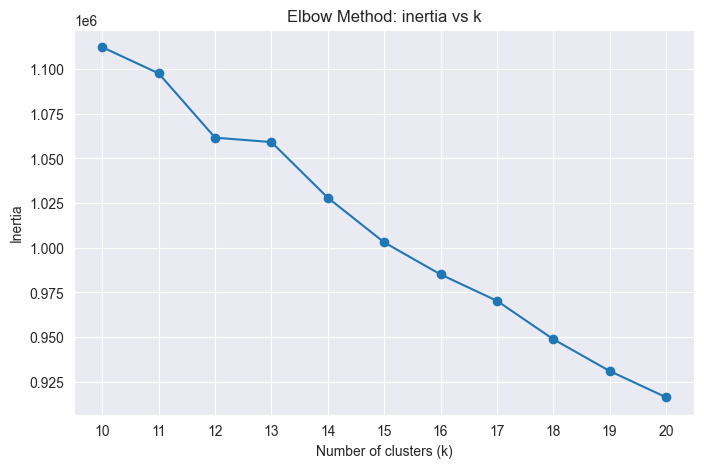

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm

# Suppose X_reduced is your dim-reduced embeddings matrix (dense, shape: (n_samples, n_components))
inertias = []
k_values = list(range(10, 21))

for k in tqdm(k_values, desc="Elbow method fitting"):
    print(f"[DEBUG] Fitting KMeans with k={k}...")
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_reduced_full)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method: inertia vs k")
plt.xticks(k_values)
plt.show()

In [25]:
from sklearn.cluster import KMeans

# Set k to 12 based on your elbow method
k_optimal = 12
print(f"[DEBUG] Training KMeans with k={k_optimal} clusters...")

kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_reduced_full)

# Optional: print cluster sizes
print("[DEBUG] Cluster counts:")
print(df['cluster'].value_counts())

# Optional: see a few sample comments from each cluster
for i in range(k_optimal):
    sample_comments = df[df['cluster'] == i]['clean_text'].head(5).tolist()
    print(f"[DEBUG] Cluster {i} sample:", sample_comments)

[DEBUG] Training KMeans with k=12 clusters...
[DEBUG] Cluster counts:
cluster
1     2473220
8      664688
0      324272
6      293889
5      263532
3      165324
7      138223
9      121850
4      117728
2       58740
10      54859
11      47158
Name: count, dtype: int64
[DEBUG] Cluster 0 sample: ['its the fake ears for me', 'here comes the suns doo doo doo doo\n\nthe bees movie', 'buddy dont give those rich womens the idea of a perfect plastic surgery', 'ah hell nah  did you guys see what he put on his face at the start', 'the end you have a litte a lips on your theet']
[DEBUG] Cluster 1 sample: ['i fake my smile everyday', 'your not fat your just beautiful', '', 'english padhta hai na english mein likhkar bhejo tum kahan par rehte ho mobile number dial karo hamara bhi laga ne ka hai', '']
[DEBUG] Cluster 2 sample: ['nice', 'nice', 'nice', 'nice nice', 'nice']
[DEBUG] Cluster 3 sample: ['they are beautiful women inside out', 'you are an inspiration', 'you are so cute', '1950s are im f

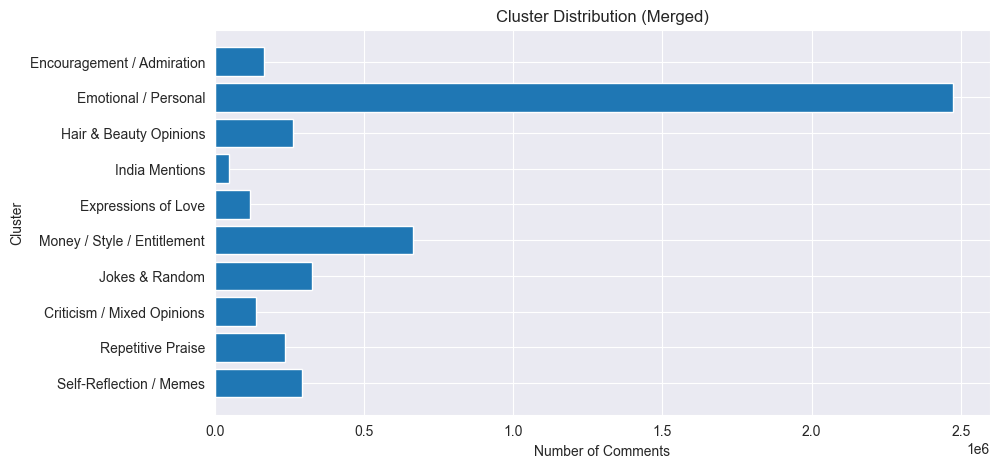

In [26]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Step 1: Map cluster IDs to descriptive labels
cluster_labels = {
    0: "Jokes & Random",
    1: "Emotional / Personal",
    2: "Short Compliments",
    3: "Encouragement / Admiration",
    4: "Expressions of Love",
    5: "Hair & Beauty Opinions",
    6: "Self-Reflection / Memes",
    7: "Criticism / Mixed Opinions",
    8: "Money / Style / Entitlement",
    9: "Repetitive 'Beautiful'",
    10: "Repetitive 'Wow'",
    11: "India Mentions"
}

df["cluster_label"] = df["cluster"].map(cluster_labels)

# Step 2: Merge repetitive clusters into a single group (optional)
merge_map = {
    "Short Compliments": "Repetitive Praise",
    "Repetitive 'Beautiful'": "Repetitive Praise",
    "Repetitive 'Wow'": "Repetitive Praise"
}

df["merged_label"] = df["cluster_label"].replace(merge_map)

# Step 3: Count frequencies after merging
cluster_counts = Counter(df["merged_label"])
merged_df = pd.DataFrame(cluster_counts.items(), columns=["Cluster", "Count"])

# Step 4: Visualization
plt.figure(figsize=(10,5))
plt.barh(merged_df["Cluster"], merged_df["Count"])
plt.xlabel("Number of Comments")
plt.ylabel("Cluster")
plt.title("Cluster Distribution (Merged)")
plt.gca().invert_yaxis()
plt.show()

In [28]:
# Count sentiment per cluster after merging
sentiment_cluster_counts = (
    df.groupby(["merged_label", "sentiment_label"])
      .size()
      .unstack(fill_value=0)
)

print(sentiment_cluster_counts)

sentiment_label              negative  neutral  positive
merged_label                                            
Criticism / Mixed Opinions       9043    22764    106416
Emotional / Personal           189635  1770022    513563
Encouragement / Admiration      15300    40922    109102
Expressions of Love               853       92    116783
Hair & Beauty Opinions          24417    65233    173882
India Mentions                    593    27179     19386
Jokes & Random                  53429   112636    158207
Money / Style / Entitlement    130220   183784    350684
Repetitive Praise                1971      209    233269
Self-Reflection / Memes         45131   101896    146862


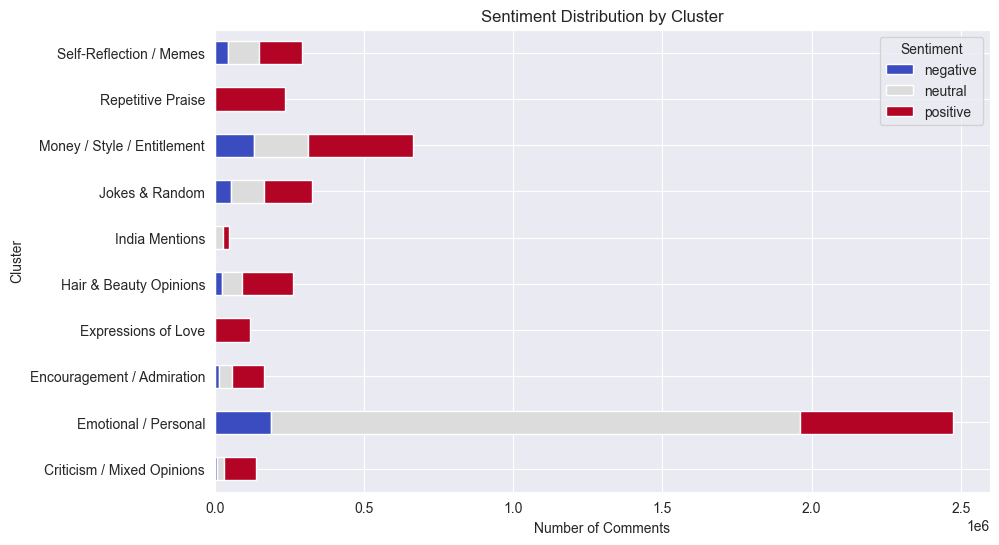

In [29]:
import matplotlib.pyplot as plt

# Stacked bar chart
sentiment_cluster_counts.plot(
    kind="barh", stacked=True, figsize=(10,6),
    colormap="coolwarm"  # optional color scheme
)

plt.xlabel("Number of Comments")
plt.ylabel("Cluster")
plt.title("Sentiment Distribution by Cluster")
plt.legend(title="Sentiment")
plt.show()

In [30]:
# Example: sentiment column already in df
print(df[['clean_text', 'cluster', 'sentiment_label']].head())

                            clean_text  cluster sentiment_label
0  they are beautiful women inside out        3        positive
1             i fake my smile everyday        1        negative
2              you not have curly hair        5         neutral
3     your not fat your just beautiful        1        positive
4                                             1         neutral


In [34]:
cluster_sentiment = df.groupby(['cluster', 'sentiment_label']).size().unstack(fill_value=0)
cluster_sentiment['total'] = cluster_sentiment.sum(axis=1)
cluster_sentiment['positive_ratio'] = cluster_sentiment.get('positive', 0) / cluster_sentiment['total']
cluster_sentiment['negative_ratio'] = cluster_sentiment.get('negative', 0) / cluster_sentiment['total']

# Reset index to keep 'cluster' as a column
cluster_sentiment = cluster_sentiment.reset_index()

# Sort and display
cluster_sentiment.sort_values('total', ascending=False).head(100)

sentiment_label,cluster,negative,neutral,positive,total,positive_ratio,negative_ratio
1,1,189635,1770022,513563,2473220,0.207650,0.076675
8,8,130220,183784,350684,664688,0.527592,0.195911
0,0,53429,112636,158207,324272,0.487884,0.164766
6,6,45131,101896,146862,293889,0.499719,0.153565
5,5,24417,65233,173882,263532,0.659814,0.092653
3,3,15300,40922,109102,165324,0.659928,0.092546
7,7,9043,22764,106416,138223,0.769886,0.065423
9,9,1083,76,120691,121850,0.990488,0.008888
4,4,853,92,116783,117728,0.991973,0.007246
2,2,763,73,57904,58740,0.985768,0.012989


In [35]:
df = df.merge(cluster_sentiment, on='cluster', how='left')

In [36]:
# show the columns in df
df.columns

Index(['commentId', 'textOriginal', 'publishedAt', 'videoId', 'channelId',
       'title', 'viewCount', 'likeCount', 'clean_text', 'sentiment_score',
       'sentiment_label', 'cluster', 'cluster_label', 'merged_label',
       'negative', 'neutral', 'positive', 'total', 'positive_ratio',
       'negative_ratio'],
      dtype='object')

/var/folders/2c/b62fj2_s0yz81crbgdm7jg8w0000gn/T/ipykernel_86705/3325472009.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(key='publishedAt', freq='M'), 'cluster_label'])


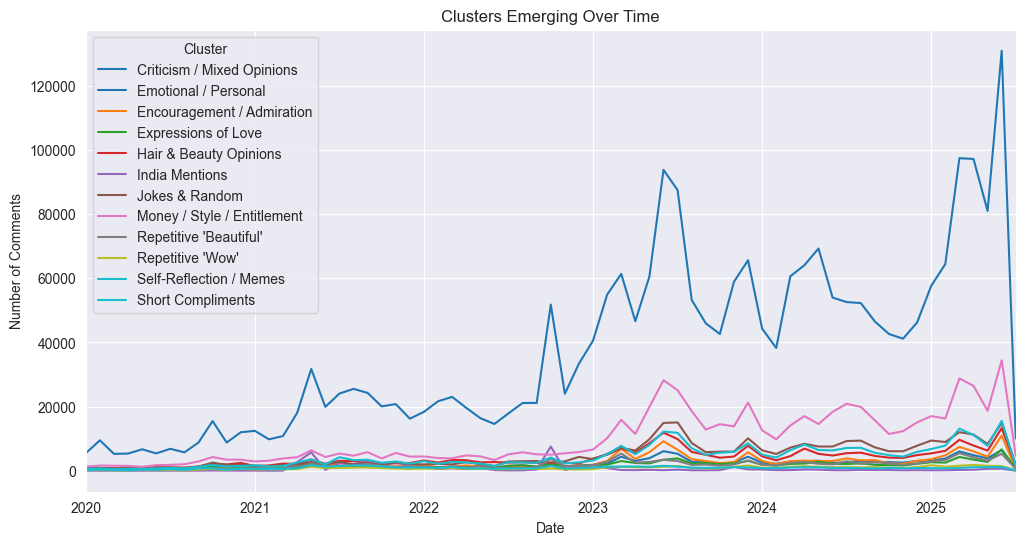

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert publishedAt to datetime if needed
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

# Group by date and cluster
cluster_time = (
    df.groupby([pd.Grouper(key='publishedAt', freq='M'), 'cluster_label'])
      .size()
      .unstack(fill_value=0)
)

# Plot clusters emerging over time
cluster_time.plot(figsize=(12, 6), colormap='tab10')
plt.title("Clusters Emerging Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.legend(title="Cluster")
plt.show()

In [51]:
 # drill down into the complaints cluster
 # Filter the cluster you're interested in
complaints_df = df[df['cluster_label'] == "Criticism / Mixed Opinions"]

# get only negative comments
complaints_df = complaints_df[complaints_df['sentiment_label'] == 'negative']

# Preview first few complaints
complaints_df[['publishedAt', 'clean_text', 'sentiment_label']].head(20)

,publishedAt,clean_text,sentiment_label
118,2021-05-18 06:55:26,i dont know but to me this hack just seem usel...,negative
270,2023-02-24 12:56:52,eeee so ugly,negative
407,2023-12-25 03:07:24,i got some weird ass hair fr is a mexican ex t...,negative
736,2024-08-04 13:07:36,why they so sad,negative
1882,2024-02-16 16:09:46,girl id kill for ur hair\nlooks so pretty btw,negative
1968,2024-06-27 08:02:35,i am so jealous my hair only does two styles l...,negative
3020,2023-11-14 05:47:14,emirabdcdiese punkte machen das ganze einfach ...,negative
3286,2023-12-27 06:13:12,i know i wanted season 4 so bad,negative
3751,2024-07-27 20:28:26,i got so scared,negative
4947,2024-08-10 20:31:36,kinda treu tho makeup is so ugly i hate it its...,negative


In [52]:
print(f"Total comments in 'Criticism / Mixed Opinions' cluster: {len(complaints_df)}")

Total comments in 'Criticism / Mixed Opinions' cluster: 9043


In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import re

# Prepare texts: each comment is a document
texts = complaints_df['clean_text'].dropna().tolist()
texts = [re.sub(r'[^a-zA-Z\s]', '', text.lower()) for text in texts]

# Create TF-IDF matrix across all comments
vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
tfidf_matrix = vectorizer.fit_transform(texts)

# Get feature names and mean TF-IDF score across documents
feature_names = vectorizer.get_feature_names_out()
scores = tfidf_matrix.mean(axis=0).A1  # average importance across all docs
tfidf_scores = pd.DataFrame({'keyword': feature_names, 'score': scores})

# Sort by importance
top_keywords = tfidf_scores.sort_values('score', ascending=False)
print(top_keywords)

   keyword     score
0      bad  0.102134
8       im  0.072899
14  pretty  0.046210
3     fake  0.040978
12  makeup  0.040118
11   looks  0.039637
10    look  0.037735
4     hair  0.035716
6     hate  0.028555
15     sad  0.028253
5     hard  0.027716
1      die  0.026710
16    shes  0.025395
17    stop  0.025015
18    ugly  0.024398
13     omg  0.024030
9     like  0.021108
2       du  0.012985
7      ich  0.012576
19     und  0.011193


In [54]:
vectorizer = TfidfVectorizer(ngram_range=(2,2), stop_words='english', max_features=15)
tfidf_matrix = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()
scores = tfidf_matrix.mean(axis=0).A1

bigram_scores = pd.DataFrame({'phrase': feature_names, 'score': scores})
print(bigram_scores.sort_values('score', ascending=False))

            phrase     score
4      im confused  0.012525
5       im jealous  0.011599
6         im sorry  0.010631
0          du bist  0.009742
1         feel bad  0.008471
9        looks bad  0.006414
2    freaking cute  0.005943
11     shes pretty  0.004555
13  wasting makeup  0.004391
7         look bad  0.004202
12      thats rude  0.003950
8        look like  0.003684
14          wie du  0.003528
10        schn wie  0.002139
3         ihr seid  0.002028


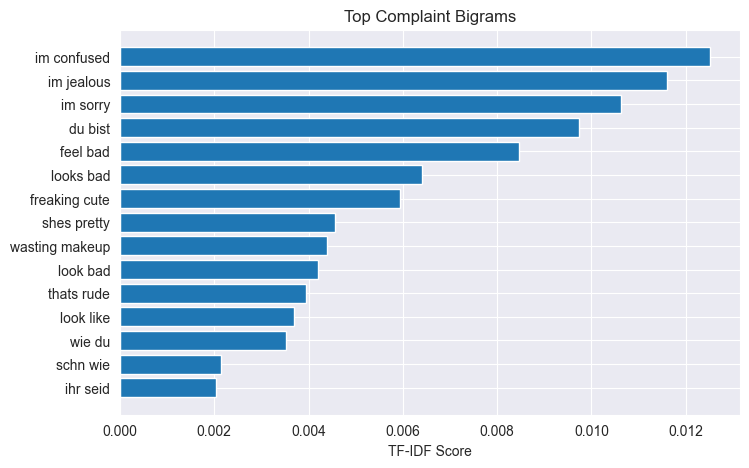

In [55]:
top_n = 15
top_bigrams = bigram_scores.sort_values('score', ascending=False).head(top_n)

plt.figure(figsize=(8,5))
plt.barh(top_bigrams['phrase'], top_bigrams['score'])
plt.gca().invert_yaxis()  # so the highest score appears at the top
plt.xlabel("TF-IDF Score")
plt.title("Top Complaint Bigrams")
plt.show()

In [58]:
from rake_nltk import Rake

# Allow only 1-2 word phrases
r = Rake(min_length=1, max_length=2)
r.extract_keywords_from_text(complaints_text)

# Get results
rake_keywords = r.get_ranked_phrases_with_scores()
rake_df = pd.DataFrame(rake_keywords, columns=["score", "keyword"])
print(rake_df.head(20))

    score            keyword
0     4.0      zurecht macht
1     4.0      zurecht macht
2     4.0  yea stopthistrend
3     4.0            ya awww
4     4.0            ya awww
5     4.0            ya awww
6     4.0     wrinkled faces
7     4.0     wrinkled faces
8     4.0          woowww dd
9     4.0    woking children
10    4.0     wispy realness
11    4.0       willy warmer
12    4.0        widows peak
13    4.0         whole clip
14    4.0        whim shaved
15    4.0        whim shaved
16    4.0           wenn dus
17    4.0           wenn dus
18    4.0       wendys motto
19    4.0       weiter hiiii


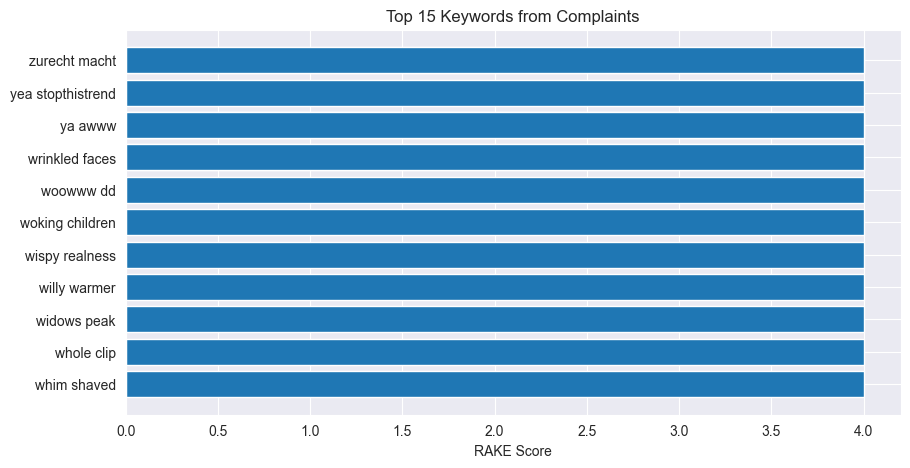

In [59]:
import matplotlib.pyplot as plt

top_n = 15
plt.figure(figsize=(10, 5))
plt.barh(rake_df['keyword'][:top_n][::-1], rake_df['score'][:top_n][::-1])
plt.xlabel("RAKE Score")
plt.title(f"Top {top_n} Keywords from Complaints")
plt.show()

In [104]:
# loreal/ontology.py
LOREAL_ONTOLOGY= {
    "Makeup": {
        "seeds": [
            "makeup", "cosmetics", "foundation", "concealer", "mascara", "eyeliner",
            "lipstick", "lip gloss", "blush", "highlighter", "eyeshadow palette",
            "Maybelline", "Lancôme", "YSL Beauty", "L'Oréal Paris"
        ],
        "keywords": [
            "make up", "brow", "lip tint", "lip oil", "matte", "dewy", "smudgeproof",
            "yslbeauty", "ysl beauty", "maybelline", "loreal paris", "lancome"
        ]
    },
    "Skincare": {
        "seeds": [
            "skincare", "skin care routine", "cleanser", "toner", "serum", "moisturizer",
            "sunscreen", "SPF", "hydration", "acne", "anti-aging", "dark spots",
            "La Roche-Posay", "CeraVe", "Vichy", "Garnier", "L'Oréal Paris"
        ],
        "keywords": [
            "retinol", "hyaluronic acid", "niacinamide", "vitamin c", "salicylic acid",
            "AHA", "BHA", "glycolic acid", "microbiome", "ceramide", "sensitive skin",
            "la roche posay", "vichy", "garnier", "revitalift"
        ]
    },
    "Haircare": {
        "seeds": [
            "haircare", "shampoo", "conditioner", "hair mask", "hair oil", "heat protectant",
            "scalp care", "anti-dandruff", "Kérastase", "L'Oréal Professionnel", "Garnier Fructis"
        ],
        "keywords": [
            "kerastase", "loreal professionnel", "fructis", "split ends", "hair fall",
            "keratin", "leave-in", "balayage", "toning"
        ]
    },
    "Fragrance": {
        "seeds": [
            "fragrance", "perfume", "eau de parfum", "eau de toilette", "sillage",
            "fragrance notes", "YSL Libre", "Armani Si", "Maison Margiela REPLICA", "Lancôme La Vie Est Belle"
        ],
        "keywords": [
            "parfum", "EDP", "EDT", "notes", "accords", "projection", "longevity",
            "ysl libre", "la vie est belle", "black opium", "my way"
        ]
    },
    "Science/Ingredients": {
        "seeds": [
            "dermatology", "clinical study", "ingredient science", "polyphenols", "peptides",
            "retinoids", "SPF testing", "photoprotection"
        ],
        "keywords": [
            "in vitro", "in vivo", "dermatologist tested", "active ingredients",
            "non comedogenic", "hypoallergenic"
        ]
    },
    "Health & Wellness": {
        "seeds": [
            "health", "wellness", "healthy skin", "skin health", "nutrition", "lifestyle",
            "physical attractiveness", "mental health", "self care", "fitness", "exercise", "holistic"
        ],
        "keywords": [
            "health", "wellness", "healthy", "skin health", "nutrition", "lifestyle",
            "physical attractiveness", "mental health", "self care", "fitness", "exercise", "holistic"
        ]
    },
    "Fashion": {
        "seeds": [
            "fashion", "style", "outfit", "clothing", "runway", "trend", "designer", "couture"
        ],
        "keywords": [
            "fashion", "style", "outfit", "clothing", "runway", "trend", "designer", "couture"
        ]
    },
    "Nails": {
        "seeds": [
            "nail care", "manicure", "pedicure", "nail polish", "gel nails", "nail art",
            "cuticle care", "nail salon", "OPI", "Essie", "Sally Hansen"
        ],
        "keywords": [
            "nail polish", "gel nails", "manicure", "pedicure", "nail art", "cuticle care",
            "opi", "essie", "sally hansen", "nail salon"
        ]
    },
    "Men's Grooming": {
        "seeds": [
            "men's grooming", "beard care", "shaving", "hair styling", "men's skincare",
            "aftershave", "men's fragrance", "L'Oréal Men Expert", "Nivea Men", "Old Spice"
        ],
        "keywords": [
            "beard oil", "shaving cream", "men's skincare", "aftershave", "men's fragrance",
            "loreal men expert", "nivea men", "old spice"
        ]
    },
    "Sustainable Beauty": {
        "seeds": [
            "sustainable beauty", "eco-friendly", "cruelty-free", "organic", "natural ingredients",
            "green beauty", "zero waste", "recyclable packaging", "clean beauty"
        ],
        "keywords": [
            "eco-friendly", "cruelty-free", "organic", "natural ingredients", "green beauty",
            "zero waste", "recyclable packaging", "clean beauty"
        ]
    },
    "Beauty Tech": {
        "seeds": [
            "beauty tech", "smart skincare", "AI beauty", "skin analysis devices", "LED masks",
            "beauty apps", "virtual try-on", "3D printed beauty", "smart mirrors"
        ],
        "keywords": [
            "smart skincare", "AI beauty", "skin analysis devices", "LED masks", "beauty apps",
            "virtual try-on", "3D printed beauty", "smart mirrors"
        ]
    }
}

GENERIC_YT = {"Health", "Lifestyle (sociology)", "Entertainment", "Society"}

In [61]:
from tqdm import tqdm

def assign_topics_by_keywords(df, ontology):
    df["topics"] = [[] for _ in range(len(df))]

    # Iterate through each topic with a progress bar
    for topic, data in tqdm(ontology.items(), desc="Assigning topics"):
        keywords = data["keywords"]
        # Lowercase keywords for faster matching
        keywords = [k.lower() for k in keywords]

        # Check each comment for any matching keywords
        df["topics"] = df.apply(
            lambda row: row["topics"] + [topic] if any(k in row["clean_text"].lower() for k in keywords) else row["topics"],
            axis=1
        )
    return df

# Usage
df = assign_topics_by_keywords(df, LOREAL_ONTOLOGY)

ERROR! Session/line number was not unique in database. History logging moved to new session 80


Assigning topics: 100%|██████████| 7/7 [08:19<00:00, 71.41s/it]


In [62]:
# look at the topics assigned
df[['clean_text', 'topics']].head(20)

,clean_text,topics
0,they are beautiful women inside out,[]
1,i fake my smile everyday,[]
2,you not have curly hair,[]
3,your not fat your just beautiful,[]
4,,[]
5,india left the chat,[]
6,i love makeup,[]
7,english padhta hai na english mein likhkar bhe...,[Skincare]
8,india,[]
9,some people arnt rich no need to flex,[]


In [63]:
# check how many comments have topics assigned
df['num_topics'] = df['topics'].apply(len)
print(f"Total comments with at least one topic: {len(df[df['num_topics'] > 0])} out of {len(df)}")

Total comments with at least one topic: 255381 out of 4723483


In [64]:
# filter to only comments with topics assigned
df_topics = df[df['num_topics'] > 0].copy()
print(f"Filtered to {len(df_topics)} comments with topics assigned")

Filtered to 255381 comments with topics assigned


In [65]:
# check the distribution of topics
from collections import Counter
import pandas as pd
all_topics = [topic for sublist in df_topics['topics'] for topic in sublist]
topic_counts = Counter(all_topics)
topic_df = pd.DataFrame(topic_counts.items(), columns=['Topic', 'Count']).sort_values(by='Count', ascending=False)
print(topic_df)

                 Topic   Count
2               Makeup  118100
1              Fashion   60922
0             Skincare   59827
4    Health & Wellness   20651
6            Fragrance    2617
5             Haircare    2494
3  Science/Ingredients      81


In [66]:
# get the schema of df_topics
df_topics.columns

Index(['commentId', 'textOriginal', 'publishedAt', 'videoId', 'channelId',
       'title', 'viewCount', 'likeCount', 'clean_text', 'sentiment_score',
       'sentiment_label', 'cluster', 'cluster_label', 'merged_label',
       'negative', 'neutral', 'positive', 'total', 'positive_ratio',
       'negative_ratio', 'topics', 'num_topics'],
      dtype='object')

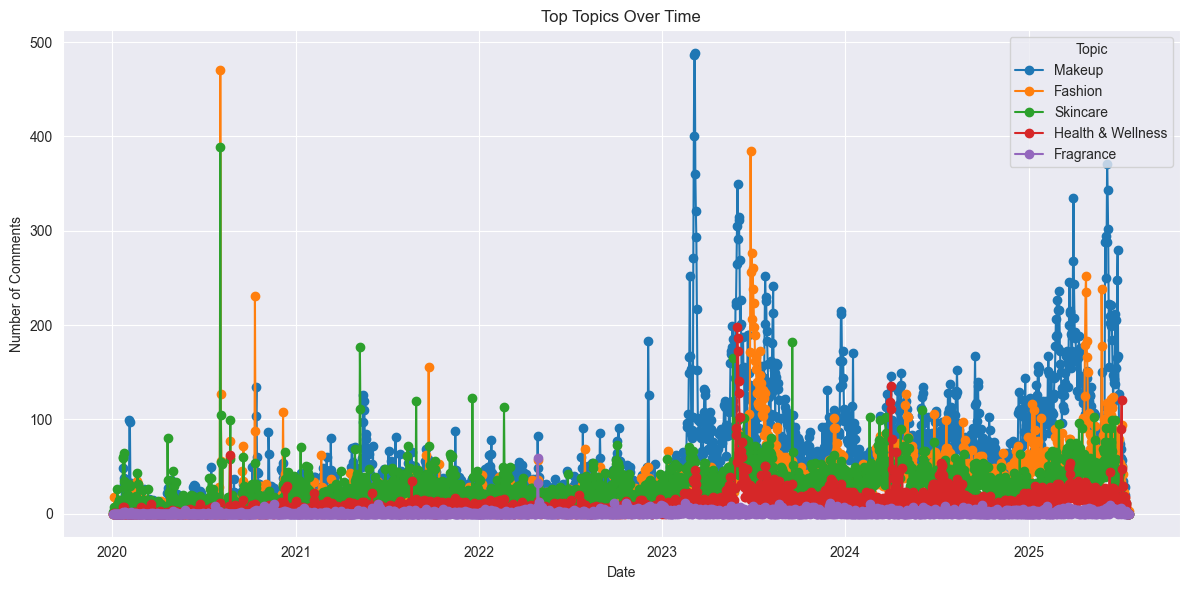

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure publishedAt is datetime
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

# Extract date only
df['date'] = df['publishedAt'].dt.date

# Explode the list of topics so each row has one topic
df_exploded = df.explode('topics')

# Count comments per topic per day
topic_trends = df_exploded.groupby(['date', 'topics']).size().unstack(fill_value=0)

# Plot top N topics (e.g., 5)
top_topics = topic_trends.sum().sort_values(ascending=False).head(5).index
topic_trends[top_topics].plot(figsize=(12,6), marker='o')
plt.title("Top Topics Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.legend(title="Topic")
plt.tight_layout()
plt.show()

In [68]:
# store df_topics to duckdb
conn = connect_db(db_path=DB_FILE)
conn.register('df_topics', df_topics)
conn.sql("CREATE OR REPLACE TABLE comments_with_topics AS SELECT * FROM df_topics")
conn.close()

[DEBUG] Connecting to database at: loreal_datathon.duckdb


In [88]:
# get the comments_with_topics from duckdb
conn = connect_db(db_path=DB_FILE)
df_topics = conn.sql("SELECT * FROM comments_with_topics").df()



[DEBUG] Connecting to database at: loreal_datathon.duckdb


In [89]:
# check the schema of df_topics
df_topics.columns

Index(['commentId', 'textOriginal', 'publishedAt', 'videoId', 'channelId',
       'title', 'viewCount', 'likeCount', 'clean_text', 'sentiment_score',
       'sentiment_label', 'cluster', 'cluster_label', 'merged_label',
       'negative', 'neutral', 'positive', 'total', 'positive_ratio',
       'negative_ratio', 'topics', 'num_topics'],
      dtype='object')

In [91]:
# get all the tables in duckdb
conn = connect_db(db_path=DB_FILE)
tables = conn.execute("SHOW TABLES").fetchdf()
print(tables)


[DEBUG] Connecting to database at: loreal_datathon.duckdb
                   name
0              comments
1    comments_processed
2  comments_with_topics
3       orphan_comments
4                  tags
5      topic_categories
6      video_categories
7            video_tags
8                videos


In [110]:
# show the first 5 rows of video
video = conn.sql("SELECT * FROM videos").df()
video

,kind,channelId,videoId,title,description,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,publishedAt
0,youtube#video,7444,12,Beautiful lips are drawn #Lip liner lipstick #...,None,None,None,PT19S,9100,76,<NA>,<NA>,2025-03-27 05:13:32
1,youtube#video,40301,20,ombre🌎 #haircolor #hairtransformation #viral #...,None,None,None,PT15S,67,1,<NA>,<NA>,2023-10-03 13:37:22
2,youtube#video,39378,36,Glow Naturally with Meabia Marry,"Discover the secret to soft, radiant skin with...",None,None,PT8S,1635,3,<NA>,<NA>,2025-04-21 07:35:53
3,youtube#video,526,68,Nikah makeup | Bridal makeup | Sliss beauty pr...,Nikah makeup | Bridal makeup | Sliss beauty pr...,en-AU,en-US,PT28S,7726,317,<NA>,11,2024-05-30 12:10:54
4,youtube#video,36970,69,SEINE Ex vs. DU🔥,None,de,de,PT14S,3017,52,<NA>,1,2023-11-08 16:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92754,youtube#video,42605,59264,🧡+♥️=💄 Viral Lipstick Mixing ll #lipstick #sho...,None,hi,hi,PT41S,16293,667,<NA>,20,2023-08-16 14:29:49
92755,youtube#video,6747,59311,Before &amp; After Powder Brow / Permanent Mak...,None,None,None,PT21S,1965,28,<NA>,<NA>,2022-08-10 13:12:14
92756,youtube#video,17538,59316,Styling White Kurti In Different Ways || Look ...,#whitekurtistyling #stylinginspiration #lookst...,en,en,PT3M45S,7290,<NA>,<NA>,10,2021-02-20 05:40:42
92757,youtube#video,26437,59339,Can girls shave their face #skincare #shaving ...,Can girls shave their face #skincare #shaving ...,en,kn,PT16S,458,8,<NA>,<NA>,2022-11-24 04:40:10


In [111]:
# assign topics to videos based on title and description
def assign_topics_to_videos(df, ontology):
    df["video_topics"] = [[] for _ in range(len(df))]
    for topic, data in tqdm(ontology.items(), desc="Assigning video topics"):
        keywords = data["keywords"]
        keywords = [k.lower() for k in keywords]

        df["video_topics"] = df.apply(
            lambda row: row["video_topics"] + [topic] if any(k in (row["title"] + " " + (row["description"] or "")).lower() for k in keywords) else row["video_topics"],
            axis=1
        )
    return df

video = assign_topics_to_videos(video, LOREAL_ONTOLOGY)

Assigning video topics: 100%|██████████| 11/11 [00:26<00:00,  2.43s/it]


In [112]:
# check the topics assigned to videos

# get the number of videos with topics assigned
video['num_video_topics'] = video['video_topics'].apply(len)
print(f"Total videos with at least one topic: {len(video[video['num_video_topics'] > 0])} out of {len(video)}")

Total videos with at least one topic: 37525 out of 92759


In [113]:
# get the distribution of video topics
all_video_topics = [topic for sublist in video['video_topics'] for topic in sublist]
video_topic_counts = Counter(all_video_topics)
video_topic_df = pd.DataFrame(video_topic_counts.items(), columns=['Topic', 'Count']).sort_values(by='Count', ascending=False)
print(video_topic_df)


                  Topic  Count
0               Fashion  26200
5                Makeup   7645
3     Health & Wellness   4800
7              Haircare   3894
4              Skincare   3543
2                 Nails   1461
1    Sustainable Beauty    621
6             Fragrance    609
10       Men's Grooming    113
8   Science/Ingredients     31
9           Beauty Tech     14


In [124]:
# get the number of comments per video by merging with df_topics
comment_counts = df_topics.groupby('videoId').size().reset_index(name='comment_count')
video = video.merge(comment_counts, on='videoId', how='left')
video['comment_count'] = video['comment_count'].fillna(0).astype(int)

In [115]:
# get the highest commented videos
top_commented_videos = video.sort_values(by='comment_count', ascending=False).head(10)
print(top_commented_videos[['videoId', 'title', 'comment_count', 'video_topics']])

       videoId                                              title  \
59932    69445                what men think no makeup is #makeup   
75387    32656  Which is your favortie? #hairstyle #shortvideo...   
29751    82728  I’m not brown🟤 🙎🏽‍♀️ #relatable #trend #shorts...   
8197     39524  another day 😍 another slay to unsolicited weig...   
3457     21883  Makeover at Shivas Signature Salon | By Shweth...   
77318    64178  What’s bad is society’s perception of perfect ...   
61369       45                 Nainowaale ne #browngirl #ytshorts   
41310    55433  This is how I face my tapes #transformation #f...   
78632    18615  Boys can wear makeup too #shortsfeed #makeup #...   
57939    70504  Skin so beautiful ………. #explore #beauty #skinc...   

       comment_count                 video_topics  
59932           7402                           []  
75387           5632                    [Fashion]  
29751           4508            [Makeup, Fashion]  
8197            2798            

In [117]:
# get create engagement score = (likeCount + commentCount) / viewCount
video['likeCount'] = pd.to_numeric(video['likeCount'], errors='coerce').fillna(0)
video['viewCount'] = pd.to_numeric(video['viewCount'], errors='coerce').replace(0, 1)  # avoid division by zero
video['engagement_score'] = (video['likeCount'] + video['comment_count']) / video['viewCount']

In [118]:
# get the top engaged videos
top_engaged_videos = video.sort_values(by='engagement_score', ascending=False).head(10)
print(top_engaged_videos[['videoId', 'title', 'engagement_score', 'video_topics']])

       videoId                                              title  \
16867    22316             Dewy bridal look? Unlocked with Lakmé⚡   
84978    60179  Imperial Meadow Brooks Wig  women &amp; men pr...   
41503    58399  #shorts #loveyourself #salon #styling #noitre ...   
77669     3105  Self Care Routine 2021 Haircutstyle, Hair colo...   
86379    49794  #straightening #bhfyp #hairstyle #hairstyles #...   
5049     81829                        beauty compilation # shorts   
21105    90332                        beauty compilation # shorts   
34409     2011  essential face wash AP ki skin ko glow deta h ...   
27117    68138              Foundation time and Finishing look..💋   
7611     60761  #like #share #comment #subscribe #youtubeshort...   

       engagement_score                          video_topics  
16867         13.342412                     [Makeup, Fashion]  
84978          7.084507                             [Fashion]  
41503               4.8                         

In [126]:
# add the video topics to df_topics by merging on videoId
df_topics = df_topics.merge(video[['videoId','video_topics']], on='videoId', how='left')


In [127]:
def calculate_relevance_score(row):
    video_topics = set(row['video_topics'])
    comment_topics = set(row['topics_comment'])
    if not comment_topics:
        return 0.0
    common_topics = video_topics.intersection(comment_topics)
    return len(common_topics) / len(comment_topics)

# rename topics in df_topics to topics_comment to avoid confusion
df_topics = df_topics.rename(columns={'topics': 'topics_comment'})


In [128]:
df_topics['relevance_score'] = df_topics.apply(calculate_relevance_score, axis=1)

In [129]:
# get the average relevance score per video
video_relevance = df_topics.groupby('videoId')['relevance_score'].mean().reset_index(name='avg_relevance_score')
video = video.merge(video_relevance, on='videoId', how='left')

In [130]:
# get the top relevant videos
top_relevant_videos = video.sort_values(by='avg_relevance_score', ascending=False).head(10)
print(top_relevant_videos[['videoId', 'title', 'avg_relevance_score', 'video_topics']])

       videoId                                              title  \
27954    81291  Jawline Defining v face slimming exercise tech...   
48015    34687  How To Choose L.A Girl Foundation /L.A Girl Pr...   
79686    35525  LOSE FACE FAT + FACE LIFT + ANTI-AGING #shorts...   
48058    35274  Sexy &amp; Long-Lasting Black Tie Wedding Gues...   
21562    68972  This is your sign to get the Shark Flexstyle #...   
79646    34763  Full On Festive Day - 2, Timeless White Kurta ...   
21628    69983  *REVEALED*♦️South Korean Beauty Secret 🤫 #shor...   
79639    34688  How To: Fall Inspired Beauty with Michele Wang...   
48030    35009  Trending Human Hair/Wigs Conpilation 2021|Type...   
79609    34131     1960&#39;s Beauty-Inspired Look | Sally Beauty   

       avg_relevance_score                   video_topics  
27954                  1.0            [Health & Wellness]  
48015                  1.0                       [Makeup]  
79686                  1.0  [Haircare, Health & Wellness]  


In [132]:
# get the videos that have both high engagement, high relevance, and high viewCount
top_videos = video[
    (video['engagement_score'] > video['engagement_score'].quantile(0.75)) &
    (video['avg_relevance_score'] > video['avg_relevance_score'].quantile(0.75)) &
    (video['viewCount'] > video['viewCount'].quantile(0.75))
].sort_values(by=['engagement_score', 'avg_relevance_score'], ascending=False)

top_videos[['videoId', 'title', 'engagement_score', 'avg_relevance_score', 'viewCount', 'video_topics']]

,videoId,title,engagement_score,avg_relevance_score,viewCount,video_topics
72973,58235,Styling Dupatta in 5 Different Way | fashion |...,0.545044,0.900000,8858,[Fashion]
63854,39564,Join @OliviaRodrigo on a journey of confidence...,0.180869,1.000000,10339,"[Makeup, Fragrance]"
58322,76374,that’s my PERFUME #fitcheck #newwave #androgyn...,0.174853,1.000000,7492,[Fashion]
87604,69744,EYEBROW &amp; MUSTACHE CLEAN UP🥰😩!! #dermaplan...,0.146921,1.000000,10652,[Makeup]
27343,71854,How To Style White Kurti In 7 Different Ways |...,0.142473,1.000000,3720,[Fashion]
...,...,...,...,...,...,...
44556,12927,BEST Wigs Styles for a ROUND Face &amp; Double...,0.040243,0.714286,47959,[Fashion]
13856,41297,GRWM: Styling A Butterfly Top Pt. II ✨ #ootd #...,0.04022,1.000000,563098,[Fashion]
13014,86518,Definitely a slay🤭 #fashion #fashioninspo #ski...,0.040191,0.926496,4737712,[Fashion]
78591,18014,Basic easy jawline defining shaping exercise t...,0.040185,1.000000,6047,"[Health & Wellness, Fashion]"
